Не стал пересчитывать вложения с учетом инфляции, так как хотел посмотреть не только на первоначальные вложения, но и на распределение их по балансу.
В процентах боялся запутаться, но думаю что если учесть инфляцию, то результат просто станет лучше.

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, SGDRegressor, LogisticRegressionCV, LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import preprocessing
from tqdm.notebook import tqdm
#from autoviz.AutoViz_Class import AutoViz_Class
import datetime
from time import sleep, time
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
RANDOM_SEED = 42

In [3]:
# def na_info(ds: pd.DataFrame) -> pd.DataFrame:
#     arr = []
#     nans_cnt = ds.isna().sum()
#     for ind, row in tqdm(nans_cnt.items(), total=nans_cnt.shape[0]):
#         name = ind
#         if ind.startswith('ind_'):
#             name = buh_codes_dict[ind[4:8]]
#         arr.append([ind, name, row, round(row / data.shape[0] * 100, 2)])
#     return pd.DataFrame(arr, columns=['column', 'name', 'nan_cnt', 'nan_perc'])


def show_num_corr(df: pd.DataFrame, features: list = None, title: str ='Корреляция между данными'):
    '''
    Корреляция между числовыми признаками набора данных
    :param df: Набор данных
    :param features: признаки
    :param title: Заголовок карты
    :return: Корр карта признаков
    '''
    plt.figure(figsize=(16, 16))
    show_df =  df
    if features is not None:
        show_df = df[features]
    mask = np.triu(np.ones_like(show_df.corr(), dtype=bool))
    heatmap = sns.heatmap(show_df.corr(),
                          mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap = heatmap.set_title(title, fontdict={'fontsize': 18}, pad=16)
    return heatmap


def get_high_coreleted_features(df: pd.DataFrame, limit: float = 0.9, method: str = 'pearson') -> pd.DataFrame:
    '''
    Получить сильно скоррелированные признаки
    :param df: Набор данных
    :param limit: только те, корреляция которых превышает лимит
    :param method: метод вычисления корреляции
    :return: Наобор вида (признак1, признак2, коэфф корреляции)
    '''
    corr_ds = df.corr(method=method)
    corr_rows = []
    for ind_row, row in corr_ds.iterrows():
        for ind_col, cell in row.items():
            if abs(cell) > limit and ind_row != ind_col:
                if [ind_col, ind_row, cell] not in corr_rows:
                    corr_rows.append([ind_row, ind_col, cell])
    return pd.DataFrame(corr_rows, columns=['feature_1', 'feature_2', 'value'])


def outliers(df: pd.DataFrame, feature: str, iqrs: float = 1.5) -> pd.DataFrame:
    '''
    Получение выбросов по интерквартильному размаху
    :param df: Набор данных
    :param feature: Признак для которого ищем выбросы
    :param iqrs: Все что выходит за  IQR * iqrs
    :return: набор данных с выбросами
    '''
    # Интерквартильный размах
    perc25 = df[feature].quantile(0.25)
    perc75 = df[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - iqrs * IQR, perc75 + iqrs * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return df[(df[feature] < low) | (df[feature] > high)]


def first_look(s: pd.Series) -> None:
    '''
    EDA для признаков
    :param s: Колонка признака
    :return: None
    '''
    saved_format = pd.options.display.float_format
    pd.options.display.float_format = '{:.2f}'.format
    print('-' * 80)
    try:
        print('Название:', s.name)
        print('Тип данных:', s.dtype.type)
        print('Количество значений:', len(s))
        print('Количество уникальных значений:', s.nunique())
        print('Количество пропусков:', s.isna().sum())
        print(f'Процент пропусков: {round((s.isna().sum() / len(s)) * 100, 2)}%')
        print('Общие статистики:')
        print(s.describe())
        print('Топ 10 уникальных значений:')
        print(s.value_counts()[:10])
    except Exception as e:
        print('Ошибка:', str(e))
    print('-' * 80)
    pd.options.display.float_format = saved_format


def plot_feature_importances(fi, columns: list, num: int=20) -> None:
    '''
    График важности признаков для моделей с feature_importances
    :param fi: feature_importances
    :param columns: какие признаки смотрим
    :param num: сколько самых важных выводим
    :return: None
    '''
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(fi, index=columns)
    mean_imp = feat_importances.nlargest(num).mean()
    feat_colors = feat_importances.apply(lambda x: 'r' if x > mean_imp else 'b')
    feat_importances.nlargest(num).plot(kind='barh', title='Feature importance')


def show_roc_auc(y_test: list, probs: list) -> None:
    '''
    График ROC AUC
    :param y_test: Истенные значения
    :param probs: Предсказанные вероятности
    :return: None
    '''
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure(figsize=(12, 8))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()


def show_lr_Importance(model: LogisticRegression, features: list, n: int=20) -> None:
    '''
    График важности признаков для моделей с LR
    :param model: экземпляр LR
    :param features: какие признаки смотрим
    :param n: сколько самых важных выводим
    :return:
    '''
    lr_coef = pd.DataFrame(model.coef_.T, columns=['coefficient'], index=features)
    lr_coef = np.abs(lr_coef)
    lr_coef = lr_coef.sort_values(by='coefficient', ascending=False)
    f, ax = plt.subplots(1, 1, figsize=(16, 10))
    df4display = lr_coef.head(n)
    sns.barplot(x=df4display['coefficient'], y=df4display.index, palette="vlag", ax=ax)
    _ = ax.set_ylabel("Признак")
    _ = ax.set_title("Значимость признаков")


def show_confusion_matrix(y_pred: list, y_true: list) -> None:
    '''
    Матрица смежности для предсказаний классификатора
    :param y_pred: предсказанные значения
    :param y_true: истинные значения
    :return:
    '''
    plt.figure(figsize=(8, 8))
    c_matrix = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    heatmap = sns.heatmap(c_matrix, annot=True, cmap='BrBG', fmt='g', annot_kws={"fontsize": 18})
    heatmap = heatmap.set_title("Confusion matrix", fontdict={'fontsize': 18}, pad=16)


def print_clssification_metrix(y_pred: list, y_true: list):
    '''
    Метрики качества для классификатора
    :param y_pred:
    :param y_true:
    :return:
    '''
    print('Precision:', metrics.precision_score(y_pred, y_true))
    print('Recall:', metrics.recall_score(y_pred, y_true))
    print('F1-score:', metrics.f1_score(y_pred, y_true))


In [8]:
# import psycopg2
# conn = psycopg2.connect(dbname='cs_finadviser', user='finadviser',
#                         password='BLgArTRCTu9DU4uSWXoU', host='localhost', port='5438')
# cursor = conn.cursor()
# cursor.execute('SELECT * FROM fa.dataset4ds')
# records = cursor.fetchall()
# cursor.close()
# conn.close()
# columns = []
# for elt in cursor.description:
#     columns.append(elt[0])
# data = pd.DataFrame(data=records, columns=columns)
# data.to_csv('data/dataset4ds.csv', index=False)
# data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572856 entries, 0 to 572855
Data columns (total 92 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   name         572856 non-null  object
 1   shortname    571797 non-null  object
 2   type         572856 non-null  object
 3   category     572856 non-null  object
 4   region       572856 non-null  int64 
 5   date_addmsp  572856 non-null  object
 6   okved        572856 non-null  object
 7   status       572856 non-null  object
 8   date_open    572856 non-null  object
 9   org_inn      572856 non-null  object
 10  year         572856 non-null  int64 
 11  ind_1110     561468 non-null  object
 12  ind_1120     561295 non-null  object
 13  ind_1130     561279 non-null  object
 14  ind_1140     561276 non-null  object
 15  ind_1150     563572 non-null  object
 16  ind_1160     561282 non-null  object
 17  ind_1170     562357 non-null  object
 18  ind_1180     561380 non-null  object
 19  in

In [9]:
data = pd.read_csv('data/dataset4ds.csv')
data.head()

,name,shortname,type,category,region,date_addmsp,okved,status,date_open,org_inn,...,ind_6321,ind_6322,ind_6323,ind_6324,ind_6325,ind_6326,ind_6330,ind_6350,ind_6300,ind_6400
0,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572856 entries, 0 to 572855
Data columns (total 92 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   name         572856 non-null  object 
 1   shortname    571797 non-null  object 
 2   type         572856 non-null  object 
 3   category     572856 non-null  object 
 4   region       572856 non-null  int64  
 5   date_addmsp  572856 non-null  object 
 6   okved        572856 non-null  object 
 7   status       572856 non-null  object 
 8   date_open    572856 non-null  object 
 9   org_inn      572856 non-null  int64  
 10  year         572856 non-null  int64  
 11  ind_1110     561468 non-null  float64
 12  ind_1120     561295 non-null  float64
 13  ind_1130     561279 non-null  float64
 14  ind_1140     561276 non-null  float64
 15  ind_1150     563572 non-null  float64
 16  ind_1160     561282 non-null  float64
 17  ind_1170     562357 non-null  float64
 18  ind_1180     561380 non-

In [11]:
# Сразу типмизируем, чтоб не путаться
data['org_inn'] = data['org_inn'].astype(str)
data['okved'] = data['okved'].astype(str)
data['name'] = data['name'].astype(str)
data['type'] = data['type'].astype(str)
data['region'] = data['region'].astype(str)
data['status'] = data['status'].astype(str)
data['date_addmsp'] = pd.to_datetime(data['date_addmsp'])
data['date_open'] = pd.to_datetime(data['date_open'])
data['year'] = data['year'].astype(int)
data[[c for c in data.columns if c.startswith('ind_')]] = data[[c for c in data.columns if c.startswith('ind_')]].astype(float)
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572856 entries, 0 to 572855
Data columns (total 92 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   name         572856 non-null  object        
 1   shortname    571797 non-null  object        
 2   type         572856 non-null  object        
 3   category     572856 non-null  object        
 4   region       572856 non-null  object        
 5   date_addmsp  572856 non-null  datetime64[ns]
 6   okved        572856 non-null  object        
 7   status       572856 non-null  object        
 8   date_open    572856 non-null  datetime64[ns]
 9   org_inn      572856 non-null  object        
 10  year         572856 non-null  int64         
 11  ind_1110     561468 non-null  float64       
 12  ind_1120     561295 non-null  float64       
 13  ind_1130     561279 non-null  float64       
 14  ind_1140     561276 non-null  float64       
 15  ind_1150     563572 non-null  floa

In [12]:
# for col in [c for c in data.columns if c.startswith('ind_')]:
#     data[col] = data[col] / data['currency']

In [13]:
# Год когда появилась первая отчетность компании
first_year = data.groupby(['org_inn'])['year'].min().rename('first_year')
data.drop('first_year', axis=1, inplace=True, errors='ignore')
data = data.join(first_year, on='org_inn')
data.head()

,name,shortname,type,category,region,date_addmsp,okved,status,date_open,org_inn,...,ind_6322,ind_6323,ind_6324,ind_6325,ind_6326,ind_6330,ind_6350,ind_6300,ind_6400,first_year
0,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
2,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
3,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014


In [14]:
# Год когда была последняя отчетность компании
last_year = data.groupby(['org_inn'])['year'].max().rename('last_year')
data.drop('last_year', axis=1, inplace=True, errors='ignore')
data = data.join(last_year, on='org_inn')
data.head()

,name,shortname,type,category,region,date_addmsp,okved,status,date_open,org_inn,...,ind_6323,ind_6324,ind_6325,ind_6326,ind_6330,ind_6350,ind_6300,ind_6400,first_year,last_year
0,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,2020
1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,2020
2,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,2020
3,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,2020
4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,2020


In [15]:
# Берем все признаки из самого раннего года организации - объединяем с основным набором
additional_features = [c for c in data.columns if c.startswith('ind_')]
additional_features.remove('ind_1600')
investments = data.sort_values(by=['org_inn', 'year']).groupby('org_inn').first()[['year', 'ind_1600'] + additional_features]
investments.columns = ['inv_year', 'inv_sum'] + ['inv_' + x for x in additional_features]
data.drop(investments.columns, axis=1, inplace=True, errors='ignore')

In [16]:
data = data.join(investments, on=['org_inn'])
data[['org_inn', 'year'] + investments.columns.tolist()].head() #.sort_values(by=['inn', 'year']).head()

,org_inn,year,inv_year,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
0,1101034216,2014,2014,132247.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1101034216,2015,2014,132247.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1101034216,2016,2014,132247.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1101034216,2018,2014,132247.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1101034216,2019,2014,132247.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572856 entries, 0 to 572855
Columns: 176 entries, name to inv_ind_6400
dtypes: datetime64[ns](2), float64(162), int64(4), object(8)
memory usage: 769.2+ MB


In [18]:
data.loc[data['inv_sum'] < 0, ['inv_sum', 'org_inn', 'date_addmsp']]

,inv_sum,org_inn,date_addmsp
52,-2.0,9723048201,2018-10-06
7138,-3.0,7743147790,2016-01-08
7139,-3.0,7743147790,2016-01-08
7140,-3.0,7743147790,2016-01-08
7141,-3.0,7743147790,2016-01-08
...,...,...,...
564136,-60.0,7727768454,2019-10-08
564137,-60.0,7727768454,2019-10-08
564138,-60.0,7727768454,2019-10-08
564139,-60.0,7727768454,2019-10-08


In [19]:
# Накопительно вычисляем сумму прибыли организации по годам - объединяем с набором
profit = data.sort_values(by=['org_inn', 'year']).groupby('org_inn').cumsum()['ind_2400']
profit.name = 'profit'
data.drop(['profit'], axis=1, inplace=True, errors='ignore')
data = data.join(profit)
data[['org_inn', 'year', 'ind_2400', 'profit'] + investments.columns.tolist()].sort_values(by=['org_inn', 'year']).head()

,org_inn,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
354544,1001007610,2014,11.0,11.0,2014,22.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354545,1001007610,2015,54.0,65.0,2014,22.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354546,1001007610,2016,23.0,88.0,2014,22.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354547,1001007610,2017,983.0,1071.0,2014,22.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354548,1001007610,2018,0.0,1071.0,2014,22.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
data.sort_values(by=['org_inn', 'year']).groupby('org_inn').last()[['year', 'ind_2400', 'profit'] + investments.columns.tolist()].head()

,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
org_inn,,,,,,,,,,,,,,,,,,,,,
1001007610,2020,150.0,1656.0,2014,22.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001009512,2020,822.0,12265.0,2013,1895.0,0.0,0.0,0.0,0.0,646.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001014417,2020,136.0,421.0,2013,1034.0,0.0,0.0,0.0,0.0,511.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001014953,2020,0.0,215.0,2013,69.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001020058,2021,4576.0,12598.0,2013,7030.0,0.0,0.0,0.0,0.0,2333.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
features = ['year', 'ind_2400', 'profit', 'result',] + investments.columns.tolist()

In [21]:
# Формируем результат деятельности организации за год как разницу между первоначальным вложением и прбылью после налогов
data['result'] = data['inv_sum'] - data['profit']
data.sample(2)

,name,shortname,type,category,region,date_addmsp,okved,status,date_open,org_inn,...,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400,profit,result
572023,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""Р-ТЕХ""","ООО ""Р-ТЕХ""",ЮЛ,Микропредприятие,77,2018-10-04,62.01,Действует,2018-03-07,7716901305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1276.0
205139,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ТЕХН...","ООО ""ТЕХНОЛОГИИ БУДУЩЕГО""",ЮЛ,Микропредприятие,39,2018-10-11,62.01,Действует,2018-10-17,3906373430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,540.0


In [22]:
# Объединяем во временный набор последние записи об организации и записи где организаци вышла в 0 плюс
# затем берем ту что была раньше
temp = pd.concat([data.sort_values(by=['org_inn', 'year']).groupby('org_inn').last(),
           data[data['result'] <= 0].sort_values(by=['org_inn', 'year']).groupby('org_inn').first()]).reset_index()
temp = temp.sort_values(by=['org_inn', 'year']).groupby(['org_inn']).first().reset_index()
temp.sample(2) #[['inn'] + features]

,org_inn,name,shortname,type,category,region,date_addmsp,okved,status,date_open,...,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400,profit,result
94177,9204573581,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ГУСТ...","ООО ""ГУСТО ГРУПП""",ЮЛ,Микропредприятие,92,2019-10-11,56.30,Действует,2019-10-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36767,5505216748,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""БЮРО...","ООО ""БДСК""",ЮЛ,Микропредприятие,55,2016-01-08,71.1,Действует,2013-02-26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1213.0,-1070.0


In [23]:
# Формироуем таргет как разницу межу годом выхода в плюс и годом инвестирования или -1 если так и не вашли в плюс
temp['target'] = temp.apply(lambda row: -1 if row['result'] > 0 else row['year'] - row['inv_year'], axis=1)
temp.sample(2)

,org_inn,name,shortname,type,category,region,date_addmsp,okved,status,date_open,...,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400,profit,result,target
17414,3444152427,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЭКВИ...","ООО ""ЭКВИТАС""",ЮЛ,Микропредприятие,34,2016-01-08,62.02,Действует,2007-10-26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3641.0,22446.0,-1
86729,7813086286,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""РАДИО КАТЮША""","АО ""РАДИО КАТЮША""",ЮЛ,Малое предприятие,78,2018-10-08,60.10,Действует,1993-08-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43906.0,44972.0,-1


In [24]:
# В рабочий набор берем только  организации где год отчетности равен году открытия
work_df = temp.loc[temp['date_open'].dt.year == temp['first_year'], ['org_inn', 'okved', 'date_open', 'inv_sum', 'target', 'region', 'year', 'first_year', 'last_year'] + ['inv_' + x for x in additional_features]]
work_df.head()

,org_inn,okved,date_open,inv_sum,target,region,year,first_year,last_year,inv_ind_1110,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
145,1001266460,23.70.2,2013-01-14,5574.0,-1,10,2020,2013,2020,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,1001266566,23.70.2,2013-01-16,1.0,-1,10,2020,2013,2020,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,1001268362,71.1,2013-02-22,2110.0,2,10,2015,2013,2020,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,1001268370,62.02,2013-02-22,514.0,1,10,2014,2013,2020,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,1001268612,62.01,2013-03-05,111.0,1,10,2014,2013,2020,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### EDA

In [25]:
for f in work_df.columns:
    first_look(work_df[f])

--------------------------------------------------------------------------------
Название: org_inn
Тип данных: <class 'numpy.object_'>
Количество значений: 28041
Количество уникальных значений: 28041
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count          28041
unique         28041
top       1001266460
freq               1
Name: org_inn, dtype: object
Топ 10 уникальных значений:
1001266460    1
7718297953    1
7718303406    1
7718302963    1
7718302924    1
7718301487    1
7718301208    1
7718300275    1
7718299862    1
7718299439    1
Name: org_inn, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Название: okved
Тип данных: <class 'numpy.object_'>
Количество значений: 28041
Количество уникальных значений: 66
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count        28041
unique          66
top       62.01   
freq  

<ipython-input-3-bd5e1109b624>:84: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(s.describe())


Процент пропусков: 0.0%
Общие статистики:
count    28041.00
mean       406.54
std       7383.15
min       -208.00
25%          0.00
50%          0.00
75%          0.00
max     960485.00
Name: inv_ind_1150, dtype: float64
Топ 10 уникальных значений:
0.00     24071
10.00      167
Name: inv_ind_1150, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Название: inv_ind_1160
Тип данных: <class 'numpy.float64'>
Количество значений: 28041
Количество уникальных значений: 23
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count    28041.00
mean        13.07
std       1329.78
min          0.00
25%          0.00
50%          0.00
75%          0.00
max     215301.00
Name: inv_ind_1160, dtype: float64
Топ 10 уникальных значений:
Ошибка: 10
--------------------------------------------------------------------------------
----------------------------------------

### Feature engineering

In [26]:
work_df = work_df[work_df['inv_sum'] > 0]

In [27]:
# np.log(work_df['inv_sum']).hist(bins=100)

In [28]:
work_df['inv_sum'] = np.log(work_df['inv_sum'])

In [29]:
work_df['inv_month'] = work_df['date_open'].dt.month

In [30]:
# work_df['target'] = work_df['target'].apply(lambda x: x if x <= 5 else 5)

In [31]:
work_df.to_csv('data/test4ds.csv', index=False)

In [32]:
work_df[['inv_sum'] + ['inv_' + x for x in additional_features]].head()

,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,inv_ind_1170,inv_ind_1180,inv_ind_1190,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
145,8.625868,0.0,0.0,0.0,0.0,2120.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,7.654443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,6.242223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,4.709530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Первая модель - LR

In [33]:
work_df.shape

(25716, 90)

In [34]:
# Формируем X
# Масштабируем числовые признаки
scaled_arr = preprocessing.StandardScaler().fit_transform(work_df[['inv_sum'] + ['inv_' + x for x in additional_features]])
X = pd.DataFrame(scaled_arr, columns=['inv_sum'] + ['inv_' + x for x in additional_features])
X.sample(2)

,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,inv_ind_1170,inv_ind_1180,inv_ind_1190,...,inv_ind_6321,inv_ind_6322,inv_ind_6323,inv_ind_6324,inv_ind_6325,inv_ind_6326,inv_ind_6330,inv_ind_6350,inv_ind_6300,inv_ind_6400
3205,0.485117,-0.006319,-0.018563,-0.006401,-0.007853,-0.057445,-0.010267,-0.014552,-0.012591,-0.015734,...,-0.009406,-0.006236,0.0,-0.008403,0.0,-0.008314,-0.011061,-0.014303,-0.009654,-0.016729
12083,1.068936,-0.006319,-0.018563,-0.006401,-0.007853,-0.047716,-0.010267,-0.014552,-0.012591,-0.015734,...,-0.009406,-0.006236,0.0,-0.008403,0.0,-0.008314,-0.011061,-0.014303,-0.009654,-0.016729


In [35]:
# Кодируем категориальные признаки
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['okved', 'region']])
X = pd.concat([X, pd.DataFrame(ohe.transform(work_df[['okved', 'region']]).astype(int), columns=ohe.get_feature_names())], axis=1)
X.sample(2)

,inv_sum,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,inv_ind_1170,inv_ind_1180,inv_ind_1190,...,x1_77,x1_78,x1_79,x1_8,x1_83,x1_86,x1_87,x1_89,x1_91,x1_92
2178,1.214943,-0.006319,-0.018563,-0.006401,-0.007853,-0.057445,-0.010267,-0.014552,-0.012591,-0.015734,...,0,0,0,0,0,0,0,0,0,0
25460,0.826198,-0.006319,-0.018563,-0.006401,-0.007853,-0.051218,-0.010267,-0.014552,-0.012591,-0.015734,...,1,0,0,0,0,0,0,0,0,0


In [37]:
# В таргет берем только признак окупиться/не окупится
y = work_df['target'].apply(lambda x: x != -1).astype(int)
y.unique()

array([0, 1])

In [39]:
# Бъем на трейн - тест
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((25716, 229), (25716,), (20572, 229), (20572,), (5144, 229), (5144,))

In [42]:
# Теперь моделька
lr = LogisticRegressionCV(Cs=10, random_state=RANDOM_SEED, class_weight='balanced', max_iter=2000)
lr.fit(X_train, y_train)
y_prob = lr.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.6660492532244089

В принципе результат не плохой - можно работать дальше

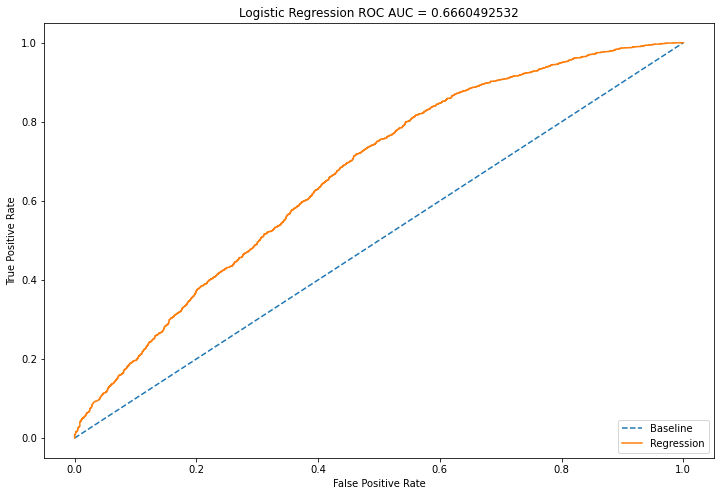

In [43]:
show_roc_auc(y_valid, y_prob[:, 1])

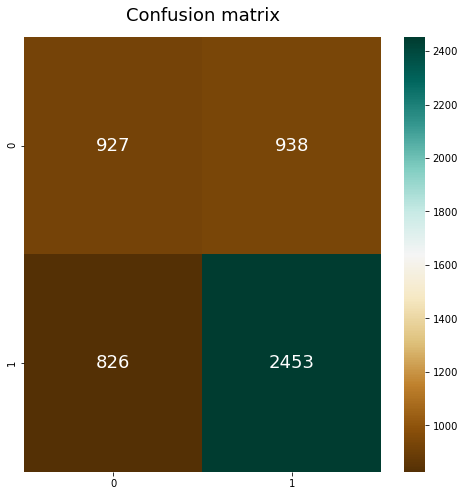

In [44]:
y_pred = lr.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

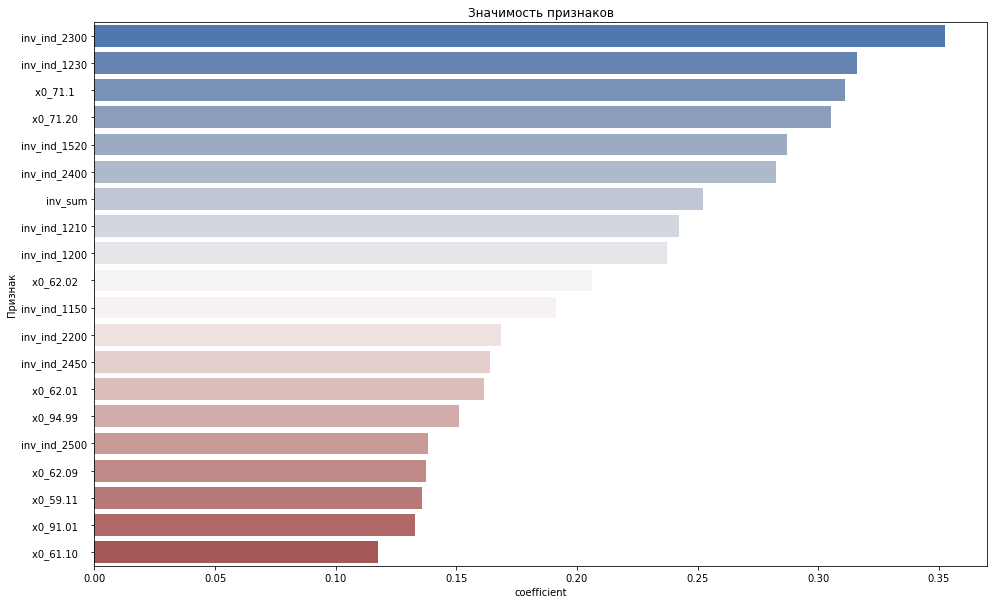

In [45]:
show_lr_Importance(lr, X.columns)

In [46]:
# По замечаниям - проверка на переобучение
y_prob = lr.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob[:, 1])

0.6641895139122639

### LGBMClassifier

In [47]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced', max_depth=3)
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.7230310662616035

Результат еще лучше, но нас интересует не просто выйдет или нет из убытков, а срок

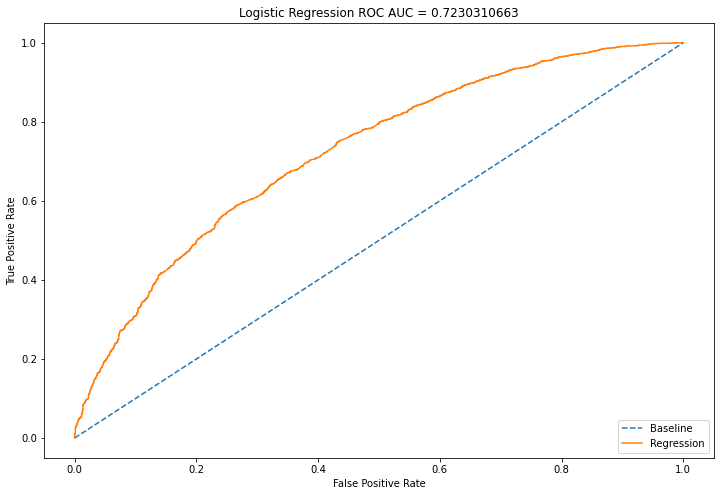

In [48]:
show_roc_auc(y_valid, y_prob[:, 1])

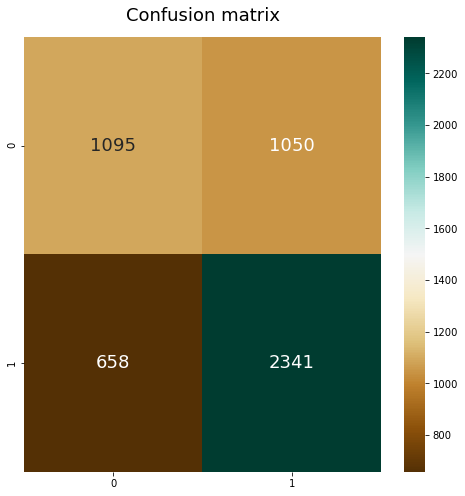

In [49]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

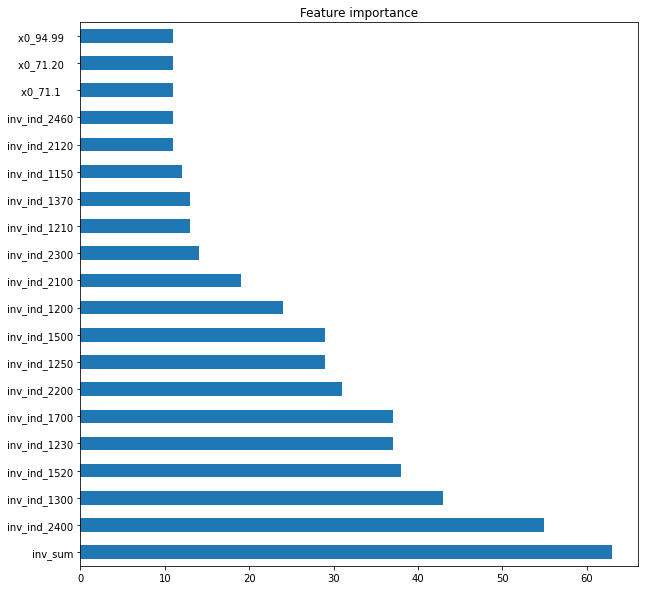

In [50]:
plot_feature_importances(model.feature_importances_, X.columns)

In [51]:
# По замечаниям - проверка на переобучение
y_prob = model.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob[:, 1])

0.7500317233536823

# !!! переобучились

### Предсказание срока выхода из убытков

In [52]:
['inv_sum'] + [x for x in work_df.columns if x.startswith('inv_ind_') and not x.startswith('inv_ind_2')]

['inv_sum',
 'inv_ind_1110',
 'inv_ind_1120',
 'inv_ind_1130',
 'inv_ind_1140',
 'inv_ind_1150',
 'inv_ind_1160',
 'inv_ind_1170',
 'inv_ind_1180',
 'inv_ind_1190',
 'inv_ind_1100',
 'inv_ind_1210',
 'inv_ind_1220',
 'inv_ind_1230',
 'inv_ind_1240',
 'inv_ind_1250',
 'inv_ind_1260',
 'inv_ind_1200',
 'inv_ind_1310',
 'inv_ind_1320',
 'inv_ind_1340',
 'inv_ind_1350',
 'inv_ind_1360',
 'inv_ind_1370',
 'inv_ind_1300',
 'inv_ind_1410',
 'inv_ind_1420',
 'inv_ind_1430',
 'inv_ind_1450',
 'inv_ind_1400',
 'inv_ind_1510',
 'inv_ind_1520',
 'inv_ind_1530',
 'inv_ind_1540',
 'inv_ind_1550',
 'inv_ind_1500',
 'inv_ind_1700',
 'inv_ind_6100',
 'inv_ind_6210',
 'inv_ind_6215',
 'inv_ind_6220',
 'inv_ind_6230',
 'inv_ind_6240',
 'inv_ind_6250',
 'inv_ind_6200',
 'inv_ind_6310',
 'inv_ind_6311',
 'inv_ind_6312',
 'inv_ind_6313',
 'inv_ind_6320',
 'inv_ind_6321',
 'inv_ind_6322',
 'inv_ind_6323',
 'inv_ind_6324',
 'inv_ind_6325',
 'inv_ind_6326',
 'inv_ind_6330',
 'inv_ind_6350',
 'inv_ind_6300',
 '

In [58]:
work_df['target'].value_counts()

-1    8672
 1    6872
 2    4456
 3    2314
 4    1332
 5     786
 0     549
 6     466
 7     214
 8      52
 9       3
Name: target, dtype: int64

In [59]:
# Мало примеров со сроком окупаемости > 4 лет - будам их все считать как 5 и более
work_df['target'] = work_df['target'].apply(lambda x: x if x < 5 else 5)

In [73]:
# Можно попробовать разный набор фичей, но для начала возьмем сумму инвестиций и ОКВЕД
features = ['inv_sum']
features = ['inv_sum', 'inv_ind_1500', 'inv_ind_1200', 'inv_ind_1300', 'inv_ind_1400']
#features = ['inv_sum'] + [x for x in work_df.columns if x.startswith('inv_ind_') and not x.startswith('inv_ind_2')]
scaled_arr = preprocessing.StandardScaler().fit_transform(work_df[features])
X = pd.DataFrame(scaled_arr, columns=features)
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['okved', 'region']])
X = pd.concat([X, pd.DataFrame(ohe.transform(work_df[['okved', 'region']]).astype(int), columns=ohe.get_feature_names())], axis=1)
y = work_df['target']
X.shape, y.shape

((25716, 153), (25716,))

In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((25716, 153), (25716,), (20572, 153), (20572,), (5144, 153), (5144,))

In [75]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced', max_depth=2)
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob, average='weighted', multi_class='ovo')

0.6420679739483955

In [63]:
np.unique(y, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5]),
 array([8672,  549, 6872, 4456, 2314, 1332, 1521]))

In [64]:
cross_val_score(model, X, y, cv=5, scoring='roc_auc_ovr_weighted')

array([0.62546706, 0.60957784, 0.60659654, 0.65214576, 0.6515365 ])

In [65]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in skf.split(X, y):
    model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced', max_depth=2)
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    print(metrics.roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted'))
#cross_val_score(model, X, y, cv=5, scoring='roc_auc_ovo_weighted')

0.6484611600074767
0.6438224056887837
0.6455660928204173
0.6475839325849257
0.6465540356074815


На самом деле для такого набора признаков и модели без настроенных гиперпараметров результат просто поразительный, следовательно нужно искать где
в предыдущих раскладках ошибка

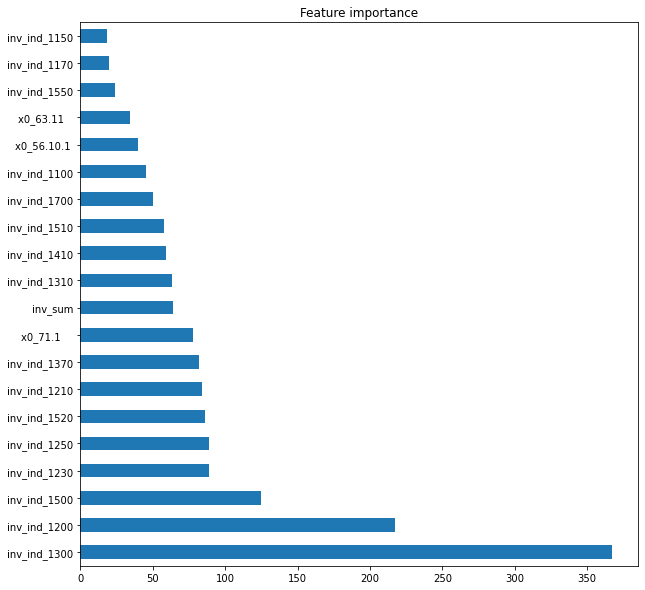

In [66]:
plot_feature_importances(model.feature_importances_, X.columns)

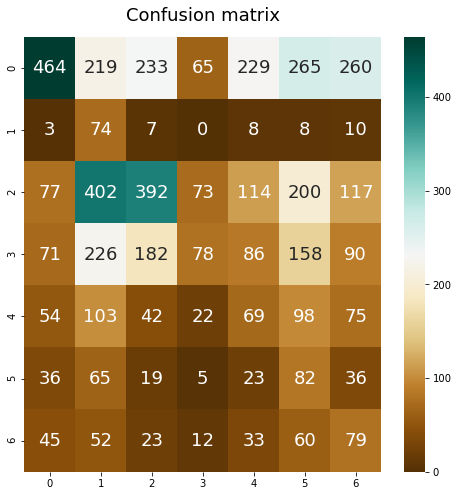

In [67]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_pred, y_valid)

In [68]:
list(zip(y_pred, y_valid))[100:110]

[(1, 1),
 (3, 2),
 (3, 3),
 (-1, 2),
 (4, 5),
 (1, 1),
 (4, -1),
 (-1, 5),
 (1, 1),
 (1, 3)]

In [69]:
# По замечаниям - проверка на переобучение
y_prob = model.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob, multi_class='ovr', average='weighted')

0.6699530256150925

# !!!Переобучились, но немного

In [70]:
model = LGBMRegressor(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
metrics.mean_absolute_error(y_valid, y_pred)

1.3368294799884821

In [71]:
list(zip(np.round(y_pred), y_valid))[100:110]

[(2.0, 1),
 (1.0, 2),
 (1.0, 3),
 (1.0, 2),
 (2.0, 5),
 (1.0, 1),
 (0.0, -1),
 (2.0, 5),
 (1.0, 1),
 (1.0, 3)]

In [72]:
np.unique(np.round(y_pred), return_counts=True)

(array([-2., -1., -0.,  1.,  2.,  3.]),
 array([   2,   61,  600, 3734,  736,   11]))